# Introduction

This is a demo of real-time data drift monitoring using Evidently. In this demo, we will train a Random Forest Regressor to predict house prices and simulate data drift by sending drifted feature(s) to the model as inputs.

Imagine we have a website for listing houses for sale, and we have a model to predict a house price based on the features of the house. The model is used in real-time, which means every time a user creates a new listing, the model gets queried for a prediction.

Because we don’t actually have a house listing website, we’ll be using a dataset from Kaggle and artifically skews the data distribution to simulate a scenario which data drift is present.

# Pre-requistes

This notebook assumes you have already **completed** step 1 to step 4 (setting up a virtual environment and installing the requirements) explained in the repo's README.md.

If we have done all the steps above correctly, right now our terminal should be in the new virtual environment we just created but not our notebook, we need to add our environment into Jupyter and select it as the Kernel we want to use.

Input the following command into your terminal:

`
pip install ipykernel
python -m ipykernel install --user --name=demoenv
`

Refresh the notebook and select the kernel. Under the *Kernel* tab on top of the notebook, hover onto *Change Kernel* and select the kernel named *demoenv*.

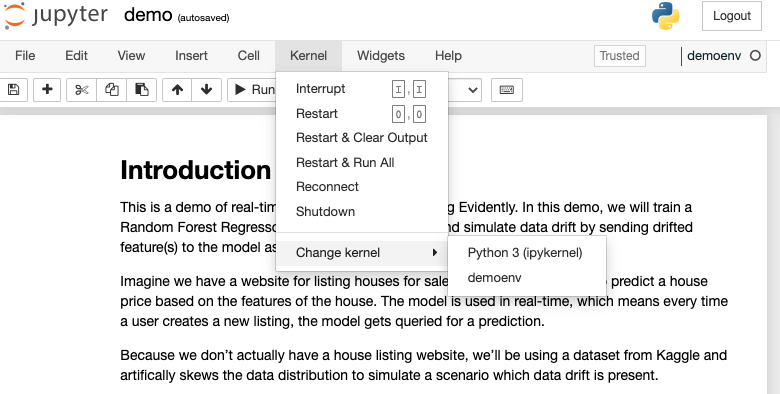

# 1. Setting up Kaggle

If you already have a Kaggle API token setup on your machine, you can skip step 1 and go to [step 2](#Step2). Otherwise, follow the steps below to set up Kaggle.

Before we can call `get_data.py` to download our dataset, we will need to log in or create a [Kaggle](https://www.kaggle.com/) account to generate an Kaggle API token.

Steps to download and set up the token:
- Go to account setting page.
- Under the API section, click create a new API token.
- The token will be downloaded as a .json file.
- Move the downloaded kaggle.json file into kaggle's folder using the following command in your terminal:

`mv ~/Downloads/kaggle.json ~/.kaggle/kaggle.json`

or 

- We can export them into the environment:

`export set KAGGLE_USERNAME=<your-kaggle-username>
export set KAGGLE_KEY=<your-kaggle-api-key>`

# 2. Downloading the dataset <a id="Step2"></a>

Within the data folder, we can find two scripts, the `get_data.py` for downloading the dataset from Kaggle and the `generate_dataset_for_demo.py` script for splitting the data into reference and production dataset.

In your terminal, input the following command:

In [ ]:
%run -i "data/get_data.py"

# 3. Splitting the data

Now we have our dataset stored in the `data` folder, the next step is to split it into production and reference dataset. 2 production dataset will be generated, one with a data distribution approximately the same as the reference dataset (no drift) and another production dataset with skewed distribtuion (drifted). To do this we can call the `generate_dataset_for_demo.py` script within our `data` folder.

In [ ]:
%run -i "data/generate_dataset_for_demo.py"

# 4. Visualising the production datasets

For simplicity, we will only use two features from our dataset.

- "bedrooms": a numerical feature represents the number of bedrooms that the house have in the house sale.

- "condition": a categorical feature ranges from 1 to 5 with 5 being the best.

To get a better understanding on how the 2 production dataset different to each other, we can also plot the distribution using a histogram.

In [ ]:
import os
import logging
import subprocess
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
prod_data_drift_path = "datasets/house_price_random_forest/production_with_drift.csv"
prod_data_no_drift_path = "datasets/house_price_random_forest/production_no_drift.csv"
ref_data_path = "datasets/house_price_random_forest/reference.csv"

In [ ]:
prod_data_drift = pd.read_csv(prod_data_drift_path)
prod_data_no_drift = pd.read_csv(prod_data_no_drift_path)
ref_data = pd.read_csv(ref_data_path)

In [ ]:
ref_data.head()

In [ ]:
features = ['bedrooms', 'condition']

normal_bedrooms_dist = prod_data_no_drift[features[0]].to_list()
drifted_bedrooms_dist = prod_data_drift[features[0]].to_list()
ref_data_bedrooms_dist = ref_data[features[0]].to_list()

normal_condition_dist = prod_data_no_drift[features[1]].to_list()
drifted_condition_dist = prod_data_drift[features[1]].to_list()
ref_data_condition_dist = ref_data[features[1]].to_list()

In [ ]:
# Histogram comparison

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(7,6))

# Bedrooms Subplots

axs[0, 0].set_xticks(np.arange(9))
axs[0, 1].set_xticks(np.arange(9))

axs[0, 0].set_title("'Bedrooms' distribution from\n reference data", size=10)
axs[0, 1].set_title("'Bedrooms' distribution from the\n production data with NO DRIFT", size=10)

# Condition Subplots

axs[1, 0].set_xticks(np.arange(7))
axs[1, 1].set_xticks(np.arange(7))

axs[1, 0].set_title("'Condition' distribution from\n reference data", size=10)
axs[1, 1].set_title("'Condition' distribution from the\n production data with NO DRIFT", size=10)

axs[0, 0].hist(ref_data_bedrooms_dist, bins=np.arange(9)-0.5, color='gray')
axs[0, 1].hist(normal_bedrooms_dist, bins=np.arange(9)-0.5, color='green')
axs[1, 0].hist(ref_data_condition_dist, bins=np.arange(7)-0.5, color='gray')
axs[1, 1].hist(normal_condition_dist, bins=np.arange(7)-0.5, color='green')

The histogram above shows the distribution of the number of bedrooms and the house conditions in the reference dataset and the production dataset with no drift, the distribution is almost identical, hence we will expect almost no data drift will be detected by Evidently.

The feature (bedrooms) distribution of the reference dataset is first computed to get the probability that represent how likely a certain number of bedrooms will appear in the reference dataset. E.g. From the plot above, we can see that 0 and 7 bedrooms has the lowest probability of being in the dataset.

In [ ]:
# Histogram comparison

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(7,6))

# Bedrooms Subplots

axs[0, 0].set_xticks(np.arange(9))
axs[0, 1].set_xticks(np.arange(9))

axs[0, 0].set_title("'Bedrooms' distribution from\n reference data", size=10)
axs[0, 1].set_title("'Bedrooms' distribution from the\n production data with DRIFT", size=10)

# Condition Subplots

axs[1, 0].set_xticks(np.arange(7))
axs[1, 1].set_xticks(np.arange(7))

axs[1, 0].set_title("'Condition' distribution from\n reference data", size=10)
axs[1, 1].set_title("'Condition' distribution from the\n production data with DRIFT", size=10)

axs[0, 0].hist(ref_data_bedrooms_dist, bins=np.arange(9)-0.5, color='gray')
axs[0, 1].hist(drifted_bedrooms_dist, bins=np.arange(9)-0.5, color='red')
axs[1, 0].hist(ref_data_condition_dist, bins=np.arange(7)-0.5, color='gray')
axs[1, 1].hist(drifted_condition_dist, bins=np.arange(7)-0.5, color='red')

Looking at the histogram for the drifted dataset, the data distribution is skewed in a way such that the number of bedrooms that appeared the least in the reference dataset has a much higher appearance in the drfited dataset which result in data drift.

# Training the Random Forest Regressor

Once the model is trained, it will be saved as `model.pkl` inside the `models` folder.

In [ ]:
%run -i "pipeline/train.py"

# Running the demo

We now have everything ready and we can run the demo with docker compose.

In [ ]:
def run_script(cmd: list, wait: bool) -> None:
    logging.info("Run %s", " ".join(cmd))
    script_process = subprocess.Popen(" ".join(cmd), stdout = subprocess.PIPE, shell = True)

    if wait:
        script_process.wait()

        if script_process.returncode != 0:
            exit(script_process.returncode)

            
def setup_logger() -> None:
    logging.basicConfig(
        level=logging.INFO, 
        format="%(asctime)s [%(levelname)s] %(message)s",
        handlers=[
            logging.StreamHandler()
        ]
    )

    
def run_docker_compose() -> None:
    '''
    Run all containers using docker compose.
    '''
    if os.system("docker image ls -q") != None:
        os.system("docker image rm $(docker image ls -q)")
    if os.system("docker volume ls -q") != None:
        os.system("docker volume rm $(docker volume ls -q)")
    logging.info("Running docker compose")
    run_script(cmd=["docker-compose", "up", "-d"], wait=True)

    
def stop_docker_compose() -> None:
    os.system("docker compose down")

# Scenario 1: No data drift

Run the cells below to call the no_data_drift_scenario() function.

In [ ]:
def send_non_drifted_data_to_model_server() -> None:
    '''
    Send data with no drift to the model server for predictions.
    '''
    os.system("python3 scenarios/no_drift.py")

def no_data_drift_scenario():
    setup_logger()
    run_docker_compose()
    time.sleep(5)
    send_non_drifted_data_to_model_server()

In [ ]:
no_data_drift_scenario()

Wait for Docker-Compose to set up.

We should now see data from the non_drifted_dataset are being sent to the inference server row by row.

To monitor data drift, we can use our pre-built Grafana dashboard which can be access [here](http://localhost:3000/).

When the metrics are calculated by Evidently, they are logged to Prometheus. To access Prometheus web interface, click [here](http://localhost:9090/). 

To stop this scenario, we can pause the cell above and run the stop_docker_compose() function below to completely stop the demo.

### Important

Grafana might ask you to login with a username and password. The default username and password is "**admin**".

In [ ]:
stop_docker_compose()

# Scenario 2: Data drift

In [ ]:
def send_drifted_data_to_model_server() -> None:
    '''
    Send data with drift to the model server for predictions.
    '''
    os.system("python3 scenarios/drift.py")

def data_drift_scenario():
    setup_logger()
    run_docker_compose()
    time.sleep(5)
    send_drifted_data_to_model_server()

In [ ]:
data_drift_scenario()

To monitor data drift, we can use our pre-built Grafana dashboard which can be access [here](http://localhost:3000/).

When the metrics are calculated by Evidently, they are logged to Prometheus. To access Prometheus web interface, click [here](http://localhost:9090/)

To stop this scenario, we can pause the cell above and run the stop_docker_compose() function below to completely stop the demo.

In [ ]:
stop_docker_compose()